In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from plotting import plot_performance_matrix
from rfc_helpers import rfc_feature_importance_analysis, stratified_k_fold, plot_rfc_feature_importances
from utils import get_study_metrics_data, get_performance_matrix
import numpy as np
import pprint
import pandas as pd
from scipy.stats import kstest, stats
import matplotlib.pyplot as plt

In [2]:
#studies_to_exclude = ['neurocube_quiroga_easy2', 'synth_mearec_neuronexus_noise10_K20_C32', 'neurocube_quiroga_easy1', 'neurocube_quiroga_difficult1', 'mea_c30', 'paired_monotrode_boyden32c', 'neurocube_sim2_11K20', 'paired_monotrode_mea64c', 'paired_english', 'synth_mearec_neuronexus_noise20_K40_C32', 'neurocube_quiroga_difficult2', 'paired_crcns', 'paired_monotrode_kampff', 'synth_mearec_neuronexus_noise20_K20_C32', 'synth_mearec_neuronexus_noise20_K10_C32', 'paired_kampff', 'paired_monotrode_crcns', 'synth_mearec_neuronexus_noise10_K10_C32', 'neurocube_sim2_2K10', 'paired_boyden32c', 'paired_mea64c', 'synth_mearec_neuronexus_noise10_K40_C32']
#ALL_AVAILABLE_STUDY_SETS=['HYBRID_JANELIA', 'LONG_DRIFT', 'LONG_STATIC', 'MANUAL_FRANKLAB', 'PAIRED_BOYDEN', 'PAIRED_CRCNS_HC1', 'PAIRED_ENGLISH', 'PAIRED_KAMPFF', 'PAIRED_MEA64C_YGER', 'PAIRED_MONOTRODE', 'SYNTH_BIONET', 'SYNTH_MAGLAND', 'SYNTH_MEAREC_NEURONEXUS', 'SYNTH_MEAREC_TETRODE', 'SYNTH_MONOTRODE', 'SYNTH_VISAPY']
#STUDY_NAMES = [study_name for study_set_name in ['HYBRID_JANELIA', 'LONG_STATIC', 'SYNTH_MAGLAND', 'SYNTH_MEAREC_TETRODE'] for study_name in SFStudySet.load(study_set_name).get_study_names() if study_name not in studies_to_exclude]

# Hybrid Janelia static only (no drift)
STUDY_NAMES = ['hybrid_static_tetrode', 'hybrid_static_siprobe',
               'LONG_STATIC_1200s_8c', 'LONG_STATIC_600s_8c', 'LONG_STATIC_300s_16c', 'LONG_STATIC_4800s_16c',
               'LONG_STATIC_300s_8c', 'LONG_STATIC_2400s_8c', 'LONG_STATIC_2400s_16c', 'LONG_STATIC_600s_16c',
               'LONG_STATIC_1200s_16c', 'LONG_STATIC_4800s_8c', 'synth_magland_noise20_K20_C8',
               'synth_magland_noise10_K10_C4', 'synth_magland_noise10_K10_C8', 'synth_magland_noise20_K10_C4',
               'synth_magland_noise20_K20_C4', 'synth_magland_noise20_K10_C8', 'synth_magland_noise10_K20_C8',
               'synth_magland_noise10_K20_C4', 'synth_mearec_tetrode_noise10_K20_C4', 'synth_mearec_tetrode_noise10_K10_C4',
               'synth_mearec_tetrode_noise20_K10_C4', 'synth_mearec_tetrode_noise20_K20_C4']

STATIC_SIPROBE_STUDY_NAMES = ['hybrid_static_siprobe', 'LONG_STATIC_1200s_8c', 'LONG_STATIC_600s_8c', 'LONG_STATIC_300s_16c',
                       'LONG_STATIC_4800s_16c', 'LONG_STATIC_300s_8c', 'LONG_STATIC_2400s_8c', 'LONG_STATIC_2400s_16c',
                       'LONG_STATIC_600s_16c', 'LONG_STATIC_1200s_16c', 'LONG_STATIC_4800s_8c',]

STATIC_TETRODE_STUDY_NAMES = ['hybrid_static_tetrode', 'synth_magland_noise20_K20_C8', 'synth_magland_noise10_K10_C4',
                       'synth_magland_noise10_K10_C8', 'synth_magland_noise20_K10_C4', 'synth_magland_noise20_K20_C4',
                       'synth_magland_noise20_K10_C8', 'synth_magland_noise10_K20_C8', 'synth_magland_noise10_K20_C4',
                       'synth_mearec_tetrode_noise10_K20_C4', 'synth_mearec_tetrode_noise10_K10_C4',
                       'synth_mearec_tetrode_noise20_K10_C4', 'synth_mearec_tetrode_noise20_K20_C4']

METRIC_NAMES = [ "firing_rate", "presence_ratio", "isi_violation",
                 "amplitude_cutoff", "snr", "max_drift", "cumulative_drift",
                 "silhouette_score", "isolation_distance", "l_ratio",
                 "nn_hit_rate", "nn_miss_rate", "d_prime"]

SORTER_NAMES = ['herdingspikes2', 'ironclust', 'jrclust',
                'kilosort', 'kilosort2', 'klusta', 'mountainsort4',
                'spykingcircus', 'tridesclous']

RANDOM_STATE = 0

In [3]:
static_tetrode_metric_data = get_study_metrics_data(
        study_names=STATIC_TETRODE_STUDY_NAMES,
        metric_names=METRIC_NAMES,
        random_state=RANDOM_STATE,
        sorter_names=SORTER_NAMES,
        include_meta=True,
        by_sorter=True
    )

In [6]:
# metric_kl_pvalues = {}
#
# for metric_name in METRIC_NAMES:
#     pvalues = pd.DataFrame(index=SORTER_NAMES, columns=SORTER_NAMES)
#     for sorter_name_A in SORTER_NAMES:
#         for sorter_name_B in SORTER_NAMES:
#             pvalues[sorter_name_A][sorter_name_B] = kstest(static_tetrode_metric_data[sorter_name_A][metric_name], static_tetrode_metric_data[sorter_name_B][metric_name])[1]
#
#     metric_kl_pvalues[metric_name] = pvalues

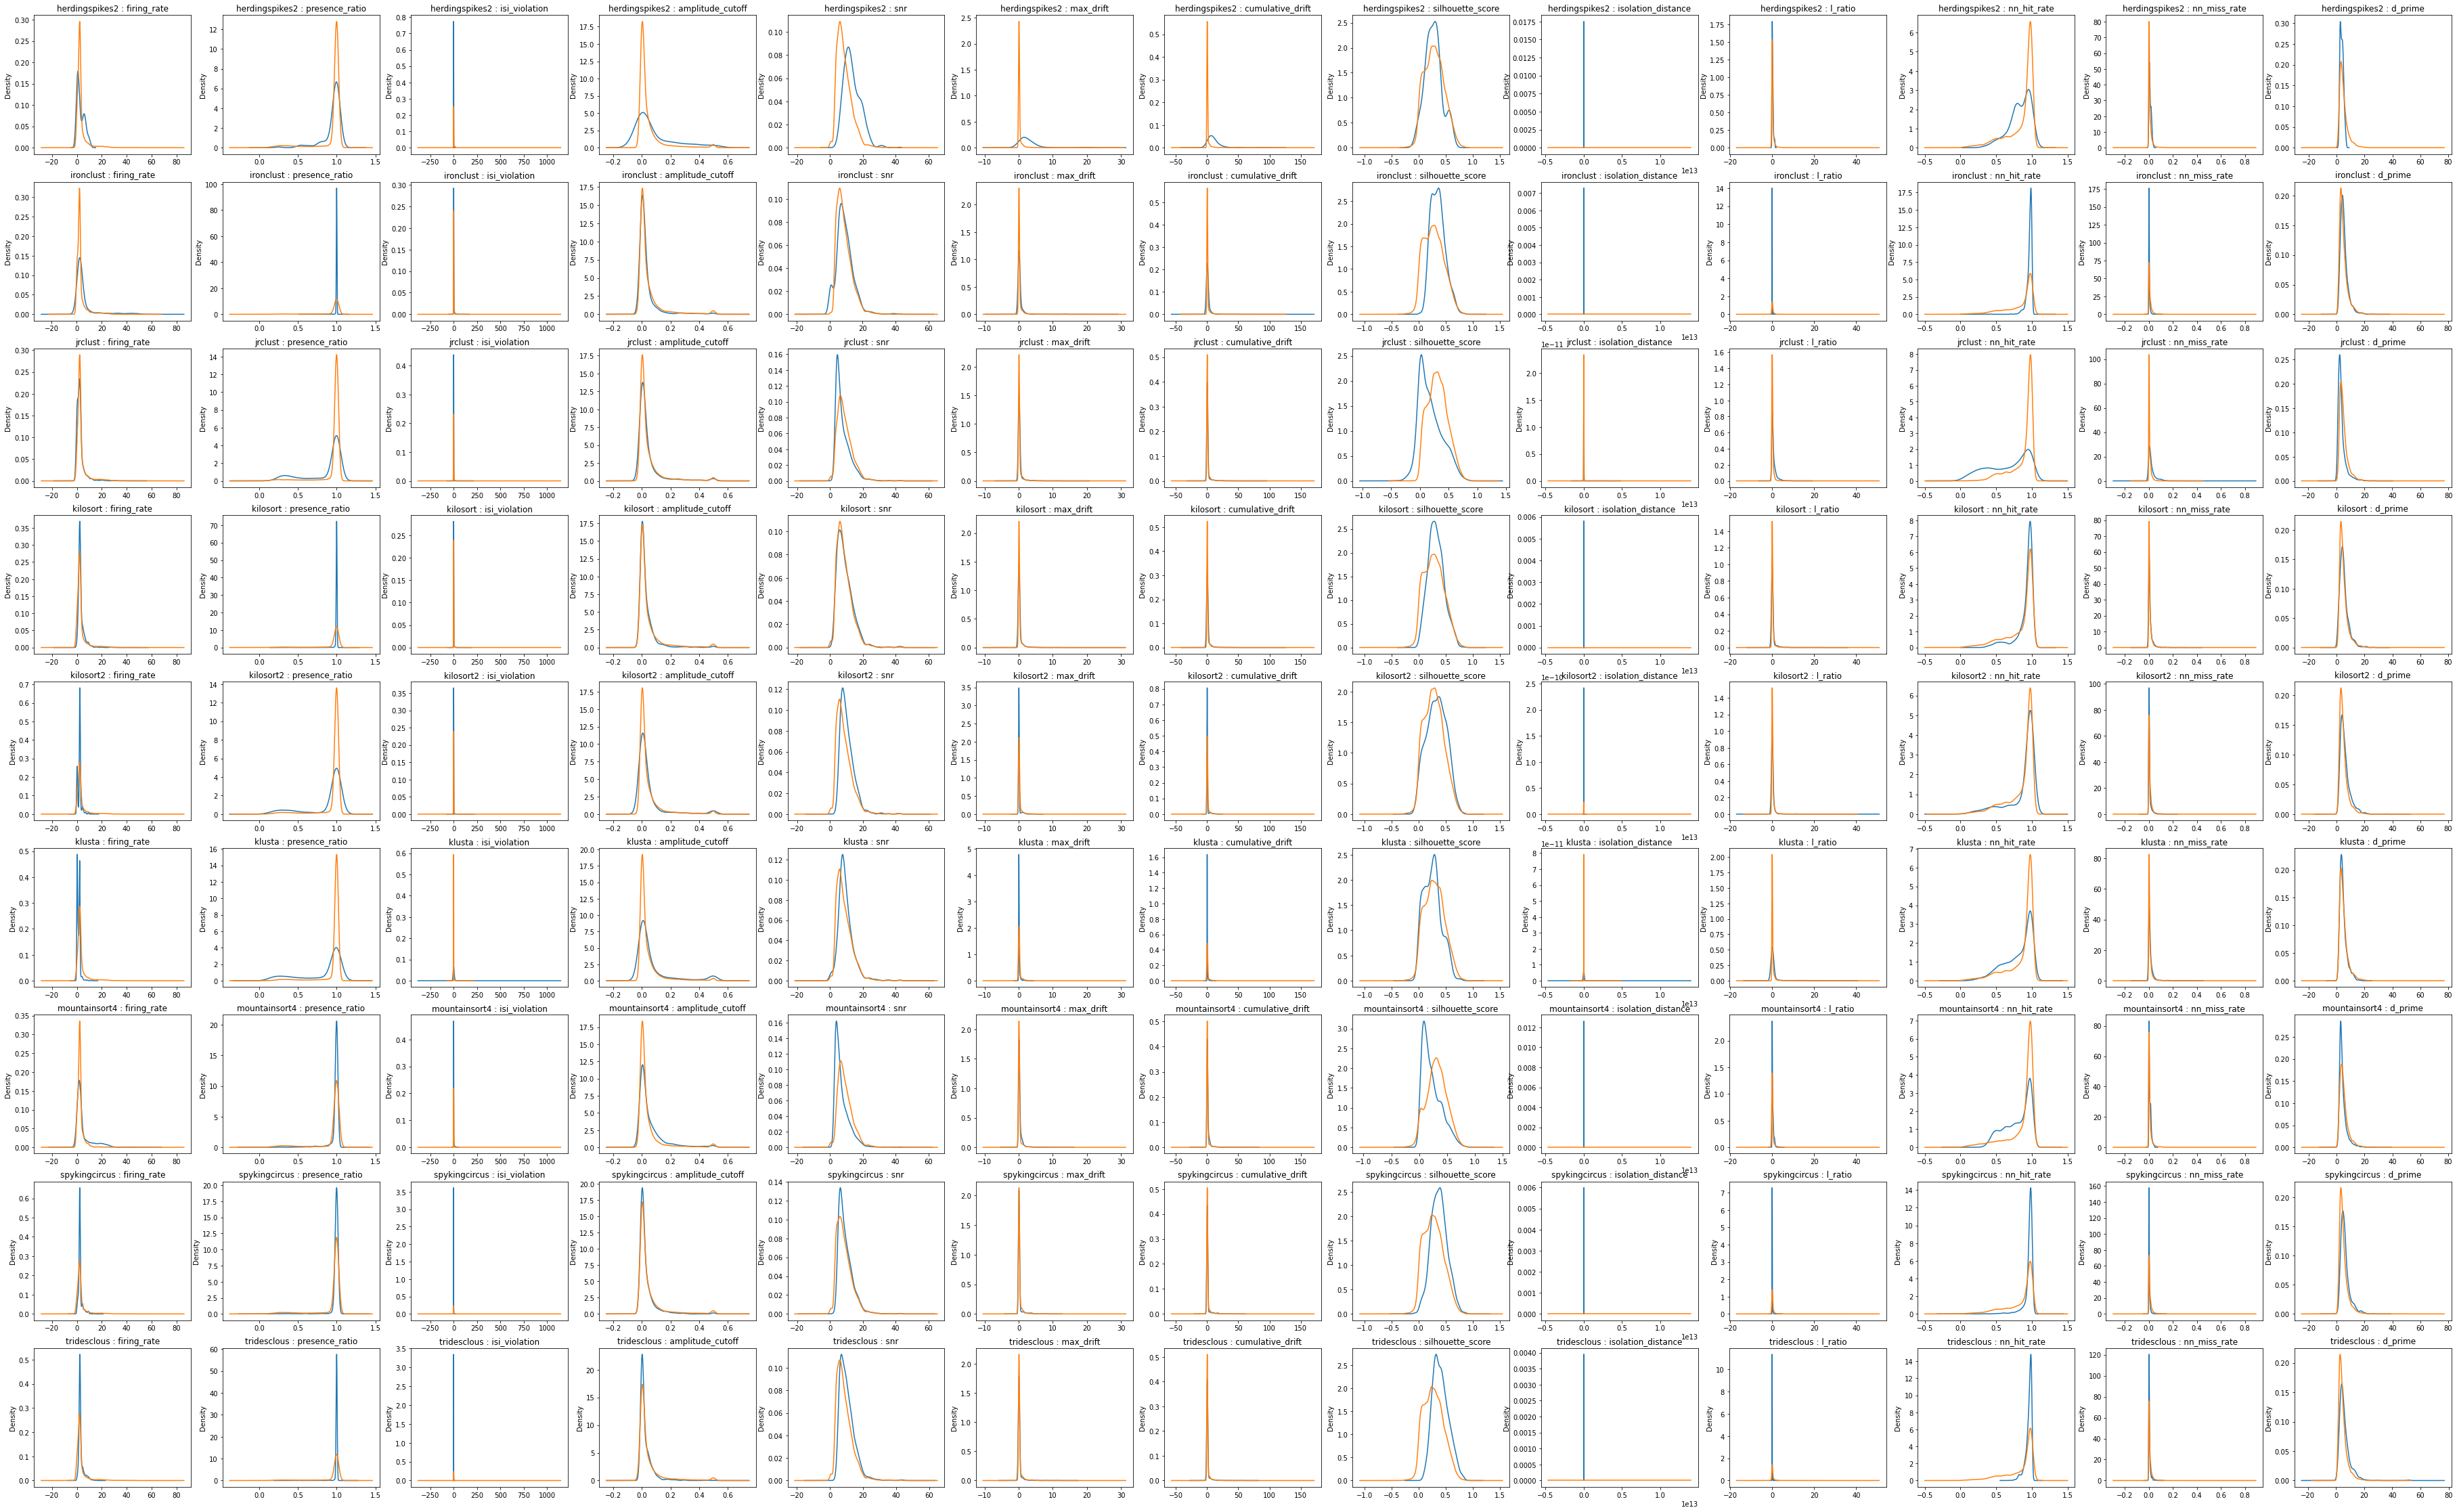

In [12]:
# distribution and distributions of all other sorter metrics.
#MIGHT BE INTERPRETING THE P VALUES THE WRONG WAY ROUND DOUBLE CHECK THIS

fig, axes = plt.subplots(nrows=len(SORTER_NAMES), ncols=len(METRIC_NAMES), squeeze=False, figsize=(64,40))

pvalues = pd.DataFrame(index=SORTER_NAMES, columns=METRIC_NAMES, dtype='float')
for i, sorter_name in enumerate(SORTER_NAMES):
    current_sorter = static_tetrode_metric_data[sorter_name]
    other_sorters = pd.concat(df for name, df in static_tetrode_metric_data.items() if name != sorter_name)
    for j, metric_name in enumerate(METRIC_NAMES):
        current_sorter[metric_name].plot.kde(ax=axes[i][j])
        other_sorters[metric_name].plot.kde(ax=axes[i][j])
        axes[i][j].set_title(f'{sorter_name} : {metric_name}')
        pvalues.loc[sorter_name][metric_name] = kstest(current_sorter[metric_name], other_sorters[metric_name])[1]

plt.savefig('kl_pvalues.pdf')

In [9]:
#pvalues = MinMaxScaler().fit_transform(pvalues)

                  firing_rate  presence_ratio  isi_violation  \
herdingspikes2   1.283155e-07    8.238055e-02   1.545893e-08   
ironclust       6.343001e-106    3.108886e-37  3.252996e-268   
jrclust          1.342253e-36    3.241299e-44   1.883084e-14   
kilosort         2.167539e-29    1.318963e-25   6.070960e-23   
kilosort2        5.510631e-21    4.587624e-13   6.932918e-93   
klusta           0.000000e+00   2.393331e-108   3.628937e-55   
mountainsort4    7.772611e-51    9.436896e-14   1.304580e-08   
spykingcircus    7.127781e-19    2.730353e-16  1.304202e-105   
tridesclous      5.165059e-40    2.289775e-24   6.915717e-17   

                amplitude_cutoff           snr     max_drift  \
herdingspikes2      6.696387e-04  7.706110e-22  3.864166e-80   
ironclust           5.042870e-10  5.661021e-08  1.058767e-04   
jrclust             2.058879e-12  1.555611e-49  1.421979e-15   
kilosort            1.537453e-13  5.845010e-02  9.510056e-02   
kilosort2           1.494911e-02  2.950